In [34]:
import numpy as np
import pandas as pd
from numpy import random
import matplotlib.pyplot as plt
from scipy.integrate import simps
import seaborn as sns
import scipy.stats as ss
from scipy.interpolate import  interp1d
from scipy import interpolate
import math
sns.set_theme()

<h1> Data indhentning

In [35]:
data_raw = np.genfromtxt('livechart3.csv', delimiter=',',skip_header=1)
data_pd = pd.DataFrame(data_raw)
data_without_nan = data_pd.dropna(subset=[7])
u235_proton = np.array(data_without_nan[0].values.tolist())
u235_nucleus = np.array(data_without_nan[1].values.tolist())
u235_yield = np.array(data_without_nan[7].values.tolist())/np.sum(np.array(data_without_nan[7].values.tolist()))

In [36]:
#Data for atomic mass ,index_col=0
data_atomic_mass = pd.DataFrame(pd.read_csv('tester3.csv',sep=';'))
list_atomic_mass = data_atomic_mass.values.tolist()

#Dataen er lidt mærkelig, så jeg kan ikke bare udtage en kolonne, og derudover skal dataen renses lidt.
protons = []
nucleus = []
#Massen er i mikro u
atomic_mass = []

for i in range(len(list_atomic_mass)):
    protons.append(list_atomic_mass[i][3])
    nucleus.append(list_atomic_mass[i][4])
    #Der forekommer mellem rum, # og så skal komma skiftes til punktum, som decimal seperator. Derudover skal den konverteres
    # til en float i stedet for en string.
    atomic_mass.append(float(list_atomic_mass[i][-2].replace('#','').replace(',','.').replace(' ','')))

#Tingene er bare nemmere som numpy array
protons = np.array(protons)
nucleus = np.array(nucleus)
#Konvertering fra mikro u til MeV/c^2
atomic_mass = np.array(atomic_mass)*10**(-6)*931.4941
#Konverteringsfaktor fra amu til Mev/c^2
#*931.4941
#Neutrones masse omregnes fra amu til MeV/c^2
neutron_mass = 1.008665*931.4941
#Masser der bruges meget så de defineres.
u235_mass = atomic_mass[(protons == 92)& (nucleus ==235)]
u236_mass = atomic_mass[(protons == 92)& (nucleus ==236)]
o16_mass = atomic_mass[(protons == 8)& (nucleus ==16)]
h1_mass = atomic_mass[(protons == 1) & (nucleus == 1)]

In [37]:
#Først kolonne er neutron energien i eV og andet kolonne er cross section i barns. Der er sket noget mærkeligt i data import så elastisk starter først ved 74.
elastic_cross =  np.genfromtxt('Elastic_cross.txt',skip_header=74,delimiter=',')
fission_cross =  np.genfromtxt('Fission_cross.txt',skip_header=1,delimiter=',')
neutron_cap_cross = np.genfromtxt('Neutron_cap_cross.txt',skip_header=1,delimiter=',')

#Den interpolerede funktion skabes, og dataen omregnes til MeV, og barns omregnes til cm^2
elastic_cross_int = interpolate.interp1d(elastic_cross[:,0]*10**(-6),elastic_cross[:,1]*10**(-24))
fission_cross_int = interpolate.interp1d(fission_cross[:,0]*10**(-6),fission_cross[:,1]*10**(-24))
neutron_cap_cross_int = interpolate.interp1d(neutron_cap_cross[:,0]*10**(-6),neutron_cap_cross[:,1]*10**(-24))

#Den atomiske densitet beregnes for U235
#Fra g/cm^3
rho235 = 18.9
#atomer pr mol
N_A = 6.022*10**(23)
#Molar masse er blot u235 atom masse i u.
u235_M = u235_mass/(931.4941)
N_u235 = (rho235 * N_A)/u235_M
#atomer pr cm^3
print(N_u235)

#Cross sections for hydrogen og oxygen importeres
hydrogen_s = np.genfromtxt("hydrogen elastisk.txt", delimiter = ',', skip_header = 1)
oxygen_s = np.genfromtxt("oxygen elastisk.txt", delimiter = ',', skip_header = 1)
hydro_s = hydrogen_s.transpose()
oxy_s = oxygen_s.transpose()

f_hydro = interpolate.interp1d(hydro_s[0]*10**(-6), hydro_s[1]*10**(-24))
f_oxy = interpolate.interp1d(oxy_s[0]*10**(-6), oxy_s[1]*10**(-24))

h2o_M = 18.01528
N_h2o = 6.022*10**23/h2o_M

[4.84232037e+22]


<h1> Fissions funktion

In [38]:
#Definere rangen for vores sandsynlighedsfordeling
x = np.linspace(0.0, 10.0, 10**4)

#Definere vores pdf
def p(x):
	return 0.4865*np.sinh(np.sqrt(2*x))*np.exp(-x)

#Den normaliseres, hvilket gøres ved simps
norm_constant = simps(p(x), x)

#pdf og cdf defineres, i sample form
own_pdf = p(x)/norm_constant
own_cdf = np.cumsum(own_pdf); own_cdf /= max(own_cdf)

#Funktionen der defineres, returnere N samples fra fordelingen
def genSamples(N):
	u = np.random.uniform(0, 1, int(N))
	func_interp = interp1d(own_cdf, x)
	samples = func_interp(u)
	return samples

In [39]:
def fission():
    #På grund af tertiær fission(tror jeg det hedder), så vil den nogle gange give fejl. Derfor så kører funktionen bare indtil det virker:)
    while True:
        try:
            #Første isotop vælges ud fra yield dataen
            first_product = np.random.choice(u235_yield, p = u235_yield.tolist())
            #Vi finder index af første isotop, så proton og nukleon tal nemmere kan findes.
            first_product_index = np.where(u235_yield == first_product)
            #Rest protoner og neutroner beregnes, så den tilsvarende dattekerne kan vælges
            rest_proton = 92-u235_proton[first_product_index] 
            rest_neutron = 236-u235_nucleus[first_product_index]

            #Der oprettes en maske der udvælger kandidaterne for datterkerne.
            #Den vælger grundstoffet med den rette mængde protoner, og så tillader den isotoper der har 0,1,2,3 eller 4 neutroner.
            mask_neutron = (u235_nucleus <= rest_neutron) & (u235_nucleus > rest_neutron-5)
            mask_proton = u235_proton == rest_proton
            mask = mask_neutron & mask_proton
            #Yield dataen udvælges og normaliseres
            tempa = u235_yield[mask]/np.sum(u235_yield[mask])
            #Andet isotop udvælges
            second_product = np.random.choice(u235_yield[mask],p = tempa.tolist())
            #Index findes
            second_product_index = np.where(u235_yield == second_product)

            #Opretter det array der skal returners, gør det bare mere overskueligt.

            first_product_mass = atomic_mass[(protons ==u235_proton[first_product_index][0]) & (nucleus ==u235_nucleus[first_product_index][0])]
            second_product_mass = atomic_mass[(protons ==u235_proton[second_product_index][0]) & (nucleus ==u235_nucleus[second_product_index][0])]

            f_a = [[u235_nucleus[first_product_index][0],u235_proton[first_product_index][0],first_product_mass[0]],[u235_nucleus[second_product_index][0],u235_proton[second_product_index][0],second_product_mass[0]]]
            
            #Antal neutroner der udsendes findes
            neutrons_produced =236 -u235_nucleus[first_product_index] - u235_nucleus[second_product_index]
            f_a.append(neutrons_produced[0])
            neutron_E = genSamples(neutrons_produced)
            f_a.append(neutron_E.tolist())

            #q værdien beregnes
            q_value = u235_mass + neutron_mass  - neutrons_produced*neutron_mass - first_product_mass - second_product_mass
            f_a.append(q_value[0])
            
            return f_a
        except:
            continue
#Returnere et array med alt informationen om fissionsprocessen
#[0] Proton og nukleon tal for første isotop
#[1] Proton og nukleon tal for andet isotop
#[2] Antal neutroner produceret
#[3] Array med neutronernes energi
#[4] q værdi, altså massen konverteret til energi, direkte efterfission. Energi fra henfald senere er ikke med
print(fission())

[[96.0, 39.0, 89345.1036137426], [136.0, 53.0, 126603.65237536178], 4.0, [1.3202582881613676, 1.884091369157871, 0.861161735279687, 0.4706406127920807], 174.57980357574706]


<h1> Reaktor geometri

In [40]:
#Brændstoffet er cirkulært så her defineres dens radius
r_fuel = 5
#Selve cellen er firkantet, her defineres dens sidelængde sådan at cellen har brændstoffet inde i sig
s_cell = r_fuel*2 +10

<h1> Klasser

In [41]:
class Neutron:
    Masse = neutron_mass #Class variable
    
    def __init__(selv, Energi,In_fuel):
        selv.Energi = Energi #Instance variable
        selv.In_fuel = In_fuel
        selv.Tid = 0 #Tid er den tid den har eksisteret.
        selv.Intereaktionstid = selv.inttid() #Intereaktionstiden beregnes
        selv.x , selv.y =selv.position() #Position findes
        selv.direction = 2*np.pi*np.random.uniform(0,1) #Neutronens retning findes
        selv.next_region = selv.distance_to_region_change()
        selv.Tid_til_region_skift = selv.next_region[3]/selv.fart() #Vi finder tiden før den er ude af reaktoren

    #En funktion der giver den nye værdier for de rigtige ting efter der har scattered. A er atom massen af atomet den støder ind i.
    def scattering(selv,A):
        selv.Tid = 0 #Tiden resettes
        angle_deflection = np.pi*np.random.uniform(-1,1) #Der vælges en tilfældig vinkel som den reflekteres med
        selv.x += np.cos(selv.direction)*selv.Intereaktionstid*selv.fart() #Nye koordinater
        selv.y += np.sin(selv.direction)*selv.Intereaktionstid*selv.fart()
        selv.direction += angle_deflection #Ny retning beregnes
        #Den nye energi beregnes samt den tabte energi
        ny_E =selv.Energi/(A+1)**2 *(np.cos(angle_deflection)+np.sqrt(A**2-np.sin(angle_deflection)*np.sin(angle_deflection)))**2
        tabt_e = selv.Energi - ny_E
        selv.Energi = ny_E
        selv.next_region = selv.distance_to_region_change() #Den næste region findes
        selv.Tid_til_region_skift = selv.next_region[3]/selv.fart() #Vi finder tiden før den er ude af reaktoren
        selv.Intereaktionstid = selv.inttid() #Den nye intereaktionstid findes
        return tabt_e #Den tabte energi returneres 

    #Funktion der giver positionen af neutronen
    def position(selv):
        r = r_fuel*np.sqrt(np.random.uniform(0,1)) #Positionen af neutronen findes i polære koordinater
        theta = 2*np.pi*np.random.uniform(0,1)
        x = r*np.cos(theta) #Omregnes til karteisiske
        y= r*np.sin(theta)
        return x, y
    
    #Funktionen finder ud af hvad den tættest skæring med et boundary er. Den er lidt messy, men essentielt finder den
    #bare afstanden til skæringspunkterne med alle siderne, og så finder den korteste
    #Det meste af koden er at finde

    def distance_to_region_change(selv):
        b = 2*(np.sin(selv.direction)*selv.y+np.cos(selv.direction)*selv.x)
        c = selv.x**2 + selv.y**2 -r_fuel**2
        d = b**2 - 4*c
        cand = [] #Array med kandidater. I arrayet vil der være et ekstra array. 
        #[0] parameteren t, der bruges til at vælge hvilken boundary den rammer
        #[1] True/False, Vil være om den er i fuel eller ej efter den har ramt boundary, så "next region"
        #[2] True/False, om den leaker eller ej.
        #[3] Hvilket boundary den interagerer med

        if d > 0:
            t1 = (-b + np.sqrt(b**2 - 4*c))/2
            t2 = (-b - np.sqrt(b**2 - 4*c))/2
            cand.append([t1,not(selv.In_fuel),False ,'f'])
            cand.append([t2,not(selv.In_fuel),False,'f'])

        #Herefter beregnes de fire siders skærings punkter.
        cand.append([(-s_cell-selv.x)/np.cos(selv.direction),False,True,'x'])
        cand.append([(s_cell-selv.y)/np.sin(selv.direction),False,True,'y'])
        cand.append([(s_cell-selv.x)/np.cos(selv.direction),False,True,'x'])
        cand.append([(-s_cell-selv.y)/np.sin(selv.direction),False,True,'y'])

        t_a = []
        for i in range(len(cand)):
            if np.round(cand[i][0],8) > 0:
                t_a.append(cand[i][0])
            else:
                t_a.append(10**10)
        t_min = min(t_a)

        x_n = np.cos(selv.direction)*t_min + selv.x
        y_n = np.sin(selv.direction)*t_min + selv.y
        d_to_region_change = np.sqrt((x_n -selv.x)**2 + (y_n - selv.y)**2)
        r_a = [t_min,cand[t_a.index(t_min)][1],cand[t_a.index(t_min)][2],d_to_region_change]
        if cand[t_a.index(t_min)][-1] == 'f':
            r_a.append(x_n)
            r_a.append(y_n)
        elif cand[t_a.index(t_min)][-1] == 'x':
            r_a.append(-x_n)
            r_a.append(y_n)
        elif cand[t_a.index(t_min)][-1] == 'y':
            r_a.append(x_n)
            r_a.append(-y_n)
        #Return array returnerer parameteren, om information om den næste position
        #[0] t  [1] In_fuel [2] Leakeage  [3] d_to_region_change [4-5] next x,y 
        return r_a

    def change_region(selv):
        selv.x = selv.next_region[4]
        selv.y = selv.next_region[5]
        selv.In_fuel = selv.next_region[1]
        selv.next_region = selv.distance_to_region_change()
        selv.Tid_til_region_skift = selv.next_region[3]/selv.fart() #Vi finder tiden før den er ude af reaktoren
        selv.Intereaktionstid = selv.inttid()

    def fart(selv):
        #Giver farten i cm/s
        return 1.383*10**7 * np.sqrt(selv.Energi)*100

    #Beregner Sigma total
    def total_makro(selv):
        return N_u235*neutron_cap_cross_int(selv.Energi) + N_u235*elastic_cross_int(selv.Energi) + N_u235*fission_cross_int(selv.Energi)

    def makro_vand(selv):
        return N_h2o*(2*f_hydro(selv.Energi) + f_oxy(selv.Energi))
    
    #En funktion der giver en intereaktionstid til neutronen
    def inttid(selv):
        mu = np.random.uniform(0,1)
        if selv.In_fuel == True: #Giver forskellig cross section alt efter om den er i brændstoffet eller ej
            t =-np.log(1-mu)/(selv.fart() * selv.total_makro())
        else:
            t =-np.log(1-mu)/(selv.fart() * selv.makro_vand())
        return t

class Atom:

    def __init__(selv, Nukleontal, Protontal, Masse):
        selv.Nukleontal = Nukleontal
        selv.Protontal = Protontal
        selv.Masse = Masse            
        

<h1> Simulationen

In [59]:

def sim(Neutroner,time):
    Neutroner = Neutroner
    Datterkerner = []
    Neutroner_leaked = []
    Scattering = 0
    Capture = 0
    Aktive_neutroner = []
    Ude_neutroner_t = []
    Tid = []
    Fri_energi = []
    Q = []
    Energi_p = 0
    t = 0
    #Omregningsfaktor
    k =10**(-9)
    dt = 0.01*k
    while t<time*k:
        for i in range(len(Neutroner)):
            #Neutronen skifter region eller intereager med boundary
            if Neutroner[i].Tid_til_region_skift < Neutroner[i].Tid:
                if Neutroner[i].next_region[2] == True:
                    mu = np.random.uniform(0,1)
                    if mu < 0.2:
                        Neutroner_leaked.append(Neutroner[i])
                        Q.append(Neutroner[i].Energi)
                        Neutroner[i] = 0
                else:
                    Neutroner[i].change_region()
                

            elif Neutroner[i].Tid > Neutroner[i].Intereaktionstid:
                mu = np.random.uniform(0,1)
                #Den totale makroskopiske cross section beregnes.
                if Neutroner[i].In_fuel == True:
                    cap_mac = N_u235*neutron_cap_cross_int(Neutroner[i].Energi)
                    e_mac = N_u235*elastic_cross_int(Neutroner[i].Energi)
                    f_mac = N_u235*fission_cross_int(Neutroner[i].Energi)
                    total_mac = cap_mac + e_mac + f_mac
                    #Fission
                    if 0 < mu and mu < f_mac/total_mac:
                        f = fission() #Vi får et array med alt information om fissionen
                        Q.append(f[4]+Neutroner[i].Energi-sum(f[3])) #Vi tilføjer q værdien til listen
                        for j in range(int(f[2])): #Vi tilføjer de nye neutroner til listen
                            n_temp = Neutron(f[3][j],True) #De nye neutroner skal have samme start position
                            n_temp.x = Neutroner[i].x +np.cos(Neutroner[i].direction)*Neutroner[i].Intereaktionstid*Neutroner[i].fart()
                            n_temp.y = Neutroner[i].y +np.sin(Neutroner[i].direction)*Neutroner[i].Intereaktionstid*Neutroner[i].fart()
                            n_temp.next_region = n_temp.distance_to_region_change()
                            n_temp.Tid_til_region_skift = n_temp.next_region[3]/n_temp.fart()
                            Neutroner.append(n_temp) 
                        for j in range(2): #Vi tilføjer de nye atomer til listen
                            Datterkerner.append(Atom(f[j][0],f[j][1],f[j][2]))
                        Neutroner[i] = 0 #Vi fjerner neutronen der blev brugt til fissionen

                    #Neutron capture
                    elif f_mac/total_mac < mu  and mu < (f_mac + cap_mac)/total_mac:
                        #Sker neutron capture, og den nye kerne
                        Datterkerner.append(Atom(236,92,u236_mass))
                        Q.append(Neutroner[i].Energi)
                        Neutroner[i] = 0
                        Capture += 1

                    #Scattering
                    elif (f_mac + cap_mac)/total_mac < mu < 1:  
                        Q.append(Neutroner[i].scattering(u235_mass))
                        Scattering += 1
                #Hvis den er i moderatoren
                elif Neutroner[i].In_fuel == False:
                    oxygen_mac = f_oxy(Neutroner[i].Energi)
                    hydro_mac = 2*f_hydro(Neutroner[i].Energi)
                    if mu < oxygen_mac/(oxygen_mac + 2*hydro_mac):
                        Q.append(Neutroner[i].scattering(o16_mass))
                    else:
                        Q.append(Neutroner[i].scattering(h1_mass))
                    Scattering += 1
            elif len(Neutroner) > 0:
                Neutroner[i].Tid += dt
        Neutroner =  [i for i in Neutroner if i != 0]
        Aktive_neutroner.append(len(Neutroner))
        Ude_neutroner_t.append(len(Neutroner_leaked))
        Energi_p += sum(Q)
        Q = []
        Fri_energi.append(Energi_p)
        Tid.append(t)
        t = t+dt
    return Tid, Aktive_neutroner,Ude_neutroner_t, Fri_energi, Scattering, Capture,(len(Datterkerner)-Capture)/2 , Datterkerner


Antal interaktioner: 6206.0
Energi frigivet: [24425.62805136] MeV
Antal neutroner i cellen:  0
Antal fissionsreaktioner: 134.0
Antal neutroner der har slippet ud:  168
Antal scattering events:  6058
Antal Neutron capture events:  14


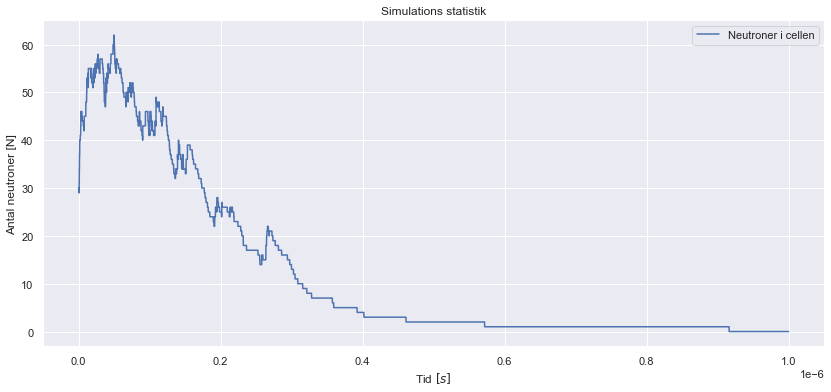

In [64]:
Neutroner = []
for i in range(30):
    Neutroner.append(Neutron(1,True))
t, a_n,u_n,q_s,scat,cap, fis,dat = sim(Neutroner,1000)

print('Antal interaktioner:', scat + cap +fis)
print('Energi frigivet: ' + str(q_s[-1]) +' MeV')
print('Antal neutroner i cellen: ',a_n[-1])
print('Antal fissionsreaktioner:', fis)
print('Antal neutroner der har slippet ud: ', u_n[-1])
print('Antal scattering events: ', scat)
print('Antal Neutron capture events: ', cap)
plt.figure(figsize=(14,6))
plt.plot(t,a_n, label = 'Neutroner i cellen')
#plt.plot(Tid,Ude_neutroner_t,label = 'Neutroner leaked')
plt.title('Simulations statistik')
plt.xlabel('Tid $[s]$')
plt.ylabel('Antal neutroner [N]')
plt.legend()
plt.show()

In [63]:
cap_a = []
fis_a = []
scat_a = []


for h in range(100):
    n_start = []
    for i in range(30):
        n_start.append(Neutron(1,True))
    print(h)
    t, a_n,u_n,q_s,scat,cap, fis,dat = sim(n_start,1000)
    df = pd.DataFrame([t,a_n,u_n,q_s])
    df.to_csv('sim_1000x100/' + str(h) + '.csv' , index=False)

df1 = pd.DataFrame([scat_a,fis_a,cap_a])
df1.to_csv('sim_1000x100/int_data.csv' , index=False)

0


KeyboardInterrupt: 

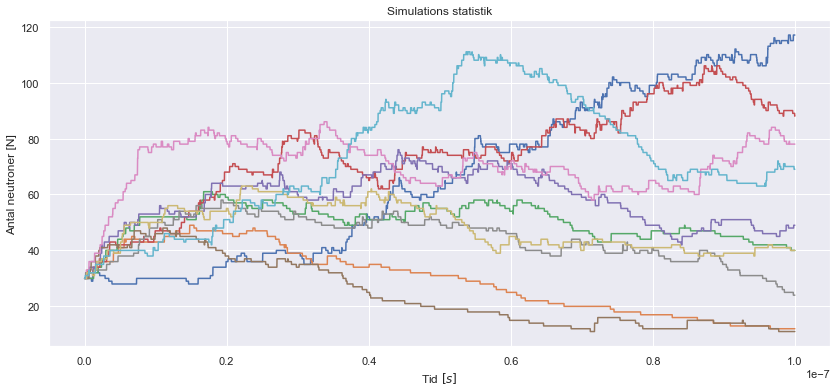

In [53]:


plt.figure(figsize=(14,6))

for h in range(10):
    s_data = np.genfromtxt('test_sim/'+ str(h) +'.csv',delimiter=',')
    plt.plot(s_data[1],s_data[2])
plt.title('Simulations statistik')
plt.xlabel('Tid $[s]$')
plt.ylabel('Antal neutroner [N]')
plt.show()
